In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0')

In [3]:
class QuadraticModel(nn.Module):
    def __init__(self, dims=10, scale=None, theta=None):
        super().__init__()
        if theta is not None and scale is not None:
            self.scale = scale
            self.theta = theta
        else:
            scale = torch.tensor(np.random.uniform(low=0.5, high=1.5, size=(dims,)).astype(np.float32))
            theta = torch.tensor(np.random.uniform(low=-1, high=1, size=(dims,)).astype(np.float32))
            self.scale = scale.to(device)
            theta = theta.to(device)
            self.theta = nn.Parameter(theta)
    def forward(self):
        return torch.sum((self.theta * self.scale) ** 2)

In [4]:
class SGD:
    def __init__(self, lr=1e-1):
        self.lr = lr
    def __call__(self, grads):
        return -self.lr * grads
class RMSProp:
    def __init__(self, lr=1e-1, decay=0.99):
        self.lr = lr
        self.decay = decay
        self.state = None
    def __call__(self, grads):
        if self.state is None:
            self.state = torch.zeros_like(grads)
        state = self.state
        state = self.decay * state + (1 - self.decay) * torch.pow(grads, 2)
        self.state = state
        update = -self.lr * grads / (torch.sqrt(state) + 1e-6)
        return update

In [16]:
losses = {'iter': [], 'loss': [], 'optim': []}

In [17]:
for _ in range(10):
    q = QuadraticModel()
    sgd = SGD()
    for i in range(20):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('SGD')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update = sgd(grads)
        q.theta.data += update

In [18]:
for _ in range(10):
    q = QuadraticModel()
    rms = RMSProp()
    for i in range(20):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('RMSProp')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update = rms(grads)
        q.theta.data += update

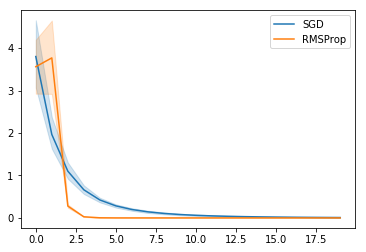

In [8]:
seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
plt.show()

In [9]:
class MetaOptimizer(nn.Module):
    def __init__(self, dim=1, hidden=20, out=1, layers=2):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden, num_layers=layers)
        self.linear = nn.Linear(hidden, out)
    def forward(self, grad, state=None):
        # seq_len x batch x size
        grad = grad.view(1, -1, 1)
        if state is None:
            h = torch.zeros(self.layers, grad.size()[1], self.hidden)
            c = torch.zeros(self.layers, grad.size()[1], self.hidden)
            h = h.to(device)
            c = c.to(device)
            state = (h, c)
        lstm_out, state = self.lstm(grad, state)
        # lstm_out.shape: seq_len x batch x hidden
        update = self.linear(lstm_out.view(-1, self.hidden))
        return update, state

In [10]:
torch.manual_seed(0)
np.random.seed(0)
meta_optimizer = MetaOptimizer()
meta_optimizer_optim = torch.optim.Adam(meta_optimizer.parameters(), lr = 1e-4)
meta_optimizer = meta_optimizer.to(device)

In [11]:
pbar = tqdm(range(2000))
state = None
for k in pbar:
    q = QuadraticModel()
    state = None
    loss = 0.
    temp_theta = 0.
    for i in range(20):
        y = q()
        loss += y
        if q.theta.grad is not None:
            q.theta.grad.zero_()
        y.backward(retain_graph=True)
        grads = q.theta.grad.detach()
        update, state = meta_optimizer(grads, state)
        update = update.view_as(q.theta.data)
        temp_theta = q.theta + update
        temp_theta.retain_grad()
        q = QuadraticModel(scale=q.scale, theta=temp_theta)
    meta_optimizer_optim.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(meta_optimizer.parameters(), 1.)
    meta_optimizer_optim.step()
    pbar.set_description('Loss: %.3f' % loss.item())

Loss: 3.440: 100%|██████████| 2000/2000 [06:08<00:00,  5.57it/s] 


In [19]:
meta_optimizer.eval()
for _ in range(10):
    q = QuadraticModel()
    state = None
    for i in range(20):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('L2L')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update, state = meta_optimizer(grads, state)
        update = update.view_as(q.theta.data)
        q.theta.data += update

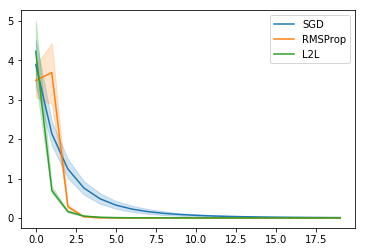

In [20]:
seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
plt.show()